In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix, precision_recall_curve, average_precision_score
import pandas as pd
from itertools import cycle
import math
from matplotlib.colors import LinearSegmentedColormap
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer
import re
import nltk
from nltk.stem import WordNetLemmatizer
import warnings


In [2]:
def evaluate_model(model, test_set, threshold=0.5, figsize=(15, 10)):
    X_test, y_test = test_set
    
    # Get predictions
    y_pred_proba = model.predict_proba(X_test)
    y_pred = (y_pred_proba >= threshold).astype(int)
    
    toxicity_categories = [
        'toxicity', 
        'severe_toxicity', 
        'obscene', 
        'sexual_explicit',
        'identity_attack', 
        'insult', 
        'threat'
    ]
    
    class_names = toxicity_categories[:y_test.shape[1]]
    
    distinct_colors = [
        '#9b59b6',  # Purple
        '#3498db',  # Blue
        '#e74c3c',  # Red
        '#2ecc71',  # Green
        '#f39c12',  # Orange
        '#1abc9c',  # Teal
        '#d35400'   # Burnt Orange
    ]
    
    # Custom purple color palettes
    purple_palette = ['#9b59b6', '#AF7AC5', '#C39BD3', '#D7BDE2', '#E8DAEF']  
    dark_purple_palette = ['#6A0DAD', '#8E44AD', '#9B59B6', '#B19CD9', '#D2B4DE']
    vibrant_purple_palette = ['#4A148C', '#6A1B9A', '#8E24AA', '#AB47BC', '#CE93D8']
    
    # Plot ROC curves
    plt.figure(figsize=figsize)
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i, class_name in enumerate(class_names):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    for i, (class_name, color) in enumerate(zip(class_names, cycle(distinct_colors))):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                label=f'{class_name} (AUC = {roc_auc[i]:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for Each Toxicity Category')
    plt.legend(loc="lower right", bbox_to_anchor=(1.15, 0))
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Plot Precision-Recall curves
    plt.figure(figsize=figsize)
    
    precision = dict()
    recall = dict()
    avg_precision = dict()
    
    for i, class_name in enumerate(class_names):
        precision[i], recall[i], _ = precision_recall_curve(y_test[:, i], y_pred_proba[:, i])
        avg_precision[i] = average_precision_score(y_test[:, i], y_pred_proba[:, i])
    
    for i, (class_name, color) in enumerate(zip(class_names, cycle(distinct_colors))):
        plt.plot(recall[i], precision[i], color=color, lw=2,
                label=f'{class_name} (AP = {avg_precision[i]:.2f})')
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curves for Each Toxicity Category')
    plt.legend(loc="lower left", bbox_to_anchor=(1.15, 0))
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Print mean ROC AUC
    mean_auc = np.mean(list(roc_auc.values()))
    print(f"\nMean ROC AUC: {mean_auc:.3f}")
    
    # Print mean Average Precision
    mean_ap = np.mean(list(avg_precision.values()))
    print(f"Mean Average Precision: {mean_ap:.3f}")
    
    # Calculate metrics
    metrics_dict = {}
    accuracy_values = []
    
    for i, class_name in enumerate(class_names):
        # Added zero_division=0 parameter to handle classes with no predicted samples
        report = classification_report(y_test[:, i], y_pred[:, i], output_dict=True, zero_division=0)
        metrics_dict[class_name] = {
            'Precision': report['1']['precision'],
            'Recall': report['1']['recall'],
            'F1-score': report['1']['f1-score'],
            'AP': avg_precision[i]
        }
        # Store accuracy for each category
        accuracy_values.append(report['accuracy'])
    
    # Create metrics DataFrame
    metrics_df = pd.DataFrame(metrics_dict).T
    
    # Plot metrics heatmap with custom vibrant purple palette
    plt.figure(figsize=(10, 6))
    
    # Create a custom colormap from the vibrant purple palette
    vibrant_cmap = LinearSegmentedColormap.from_list("vibrant_purple", vibrant_purple_palette[::-1])
    
    sns.heatmap(metrics_df, annot=True, cmap=vibrant_cmap, fmt='.3f', 
                cbar_kws={'label': 'Score'}, vmin=0, vmax=1)
    plt.title('Classification Metrics per Toxicity Category', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Plot confusion matrices
    n_classes = len(class_names)
    n_cols = 3  # Number of columns in the grid
    n_rows = math.ceil(n_classes / n_cols)  # Calculate number of rows needed
    
    plt.figure(figsize=(15, 4*n_rows))
    
    # Create custom colormaps from the provided purple palettes
    # Alternate between the custom and dark purple palettes for variety
    custom_cmaps = []
    for i in range(len(class_names)):
        if i % 2 == 0:
            # Create a colormap from the custom purple palette
            custom_cmaps.append(LinearSegmentedColormap.from_list(f"custom_purple_{i}", 
                                                                 purple_palette[::-1]))
        else:
            # Create a colormap from the dark purple palette
            custom_cmaps.append(LinearSegmentedColormap.from_list(f"dark_purple_{i}", 
                                                                 dark_purple_palette[::-1]))
    
    for i, class_name in enumerate(class_names):
        # Calculate confusion matrix
        cm = confusion_matrix(y_test[:, i], y_pred[:, i])
        
        # Convert to percentages (safely handling division by zero)
        row_sums = cm.sum(axis=1)[:, np.newaxis]
        # Replace zeros with ones to avoid division by zero
        safe_row_sums = np.where(row_sums == 0, 1, row_sums)
        cm_percentage = cm.astype('float') / safe_row_sums * 100
        
        # Plot
        plt.subplot(n_rows, n_cols, i+1)
        sns.heatmap(cm_percentage, annot=True, fmt=',.1f', cmap=custom_cmaps[i],
                    xticklabels=['Non-Toxic', 'Toxic'],
                    yticklabels=['Non-Toxic', 'Toxic'])
        
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title(f'{class_name.replace("_", " ").title()}', fontsize=12, fontweight='bold')
        
        # Add a "%" sign to the annotations
        for t in plt.gca().texts:
            t.set_text(t.get_text() + "%")
    
    plt.tight_layout()
    plt.show()
    
    # Print classification report for each class
    print("\nDetailed Classification Report:")
    print("-" * 50)
    for i, class_name in enumerate(class_names):
        print(f"\nCategory: {class_name}")
        # Added zero_division=0 parameter to handle classes with no predicted samples
        print(classification_report(y_test[:, i], y_pred[:, i], zero_division=0))
    
    # Calculate and print mean metrics
    mean_metrics = metrics_df.mean()
    print("\nMean Metrics Across All Toxicity Categories:")
    print("-" * 50)
    for metric, value in mean_metrics.items():
        print(f"{metric}: {value:.3f}")
    
    # Calculate mean accuracy across all categories
    mean_accuracy = np.mean(accuracy_values)
    
    # Create a horizontal bar chart with the 6 metrics
    plt.figure(figsize=(12, 6))
    
    # Define metrics and their values
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score', 'ROC AUC', 'PR AUC']
    values = [
        mean_accuracy, 
        mean_metrics['Precision'], 
        mean_metrics['Recall'], 
        mean_metrics['F1-score'],
        mean_auc,
        mean_ap
    ]
    
    # Create a light color for most bars and vibrant purple for PR AUC
    colors = ['#D7BDE2'] * 5 + ['#6A1B9A']  # Light purple for most, vibrant purple for PR AUC
    
    # Create horizontal bar chart
    bars = plt.barh(metrics, values, color=colors)
    
    # Add value annotations beside each bar
    for bar in bars:
        width = bar.get_width()
        plt.text(width + 0.01, bar.get_y() + bar.get_height()/2, f'{width:.3f}', 
                 va='center', fontweight='bold')
    
    # Customize the plot
    plt.xlim(0, 1.1)
    plt.title('Mean Performance Metrics', fontsize=16, fontweight='bold')
    plt.xlabel('Score', fontsize=12)
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return {
        'roc_auc': roc_auc,
        'mean_auc': mean_auc,
        'avg_precision': avg_precision,
        'mean_ap': mean_ap,
        'metrics': metrics_dict
    }


In [3]:
# Load the dataset
df = pd.read_csv("../data/all_data.csv")

# Basic cleaning
df['comment_text'] = df['comment_text'].fillna('')

# Define toxic categories (target variables)
toxic_categories = ['toxicity', 'severe_toxicity', 'obscene', 'sexual_explicit',
                   'identity_attack', 'insult', 'threat']

print(f"Data loaded with shape: {df.shape}")
print(f"Target categories: {toxic_categories}")

# Create feature matrix (X) and target matrix (y)
X = df['comment_text']  # Using the raw text as features
y = df[toxic_categories].values  # Multi-label target matrix

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=df['toxicity'] >= 0.5
)

Data loaded with shape: (1999516, 46)
Target categories: ['toxicity', 'severe_toxicity', 'obscene', 'sexual_explicit', 'identity_attack', 'insult', 'threat']


In [4]:
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove special characters and numbers
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = nltk.word_tokenize(text)
    return ' '.join([lemmatizer.lemmatize(token) for token in tokens])

X_train_processed = X_train.apply(preprocess_text)
X_test_processed = X_test.apply(preprocess_text)


In [5]:
# Create TF-IDF features
tfidf_vectorizer = TfidfVectorizer(
    max_features=20000,  
    min_df=3,            # Minimum document frequency
    max_df=0.9,          # Maximum document frequency
    ngram_range=(1, 3),  # Include unigrams, bigrams, and trigrams
    stop_words='english'
)


# Transform the text data to TF-IDF features
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print(f"Training set shape: {X_train_tfidf.shape}")
print(f"Testing set shape: {X_test_tfidf.shape}")
print(f"Target shape: {y_train.shape}")


Training set shape: (1599612, 20000)
Testing set shape: (399904, 20000)
Target shape: (1599612, 7)


In [ ]:
# Calculate mean area under precision-recall curve across all labels.
def pr_auc_score(y_true, y_pred):
    pr_aucs = []
    
    for i in range(y_true.shape[1]):
        try:
            precision, recall, _ = precision_recall_curve(y_true[:, i], y_pred[:, i])
            pr_auc = auc(recall, precision)
            pr_aucs.append(pr_auc)
        except Exception as e:
            warnings.warn(f"Error calculating PR AUC for label {i}: {e}")
            pr_aucs.append(0.0)  # Default to 0 on error
    
    if not pr_aucs:
        return 0.0
    
    return np.mean(pr_aucs)

def optimize_multilabel_classifier(
    X_train, y_train, X_test, y_test, toxic_categories,
    use_random_search=False,
    n_iter=10,
    cv=3,
    n_jobs=1,
    verbose=1,
    visualize=True,
    reduced_params=True
):
    
    # Define parameter grid based on reduced_params flag
    if reduced_params:
        # Smaller parameter grid
        param_grid = {
            'estimator__C': [0.1, 1.0, 10.0],
            'estimator__penalty': ['l2'],  # Only l2 penalty
            'estimator__class_weight': [None, 'balanced'],
            'estimator__solver': ['liblinear'],
            'estimator__max_iter': [1000]
        }
    else:
        # Full parameter grid
        param_grid = {
            'estimator__C': [0.01, 0.1, 1.0, 10.0, 100.0],
            'estimator__penalty': ['l1', 'l2'],
            'estimator__class_weight': [None, 'balanced'],
            'estimator__solver': ['liblinear'],
            'estimator__max_iter': [1000]
        }
    
    # Initialize base classifier
    base_classifier = LogisticRegression(random_state=42)
    
    # Create OneVsRestClassifier
    multilabel_classifier = OneVsRestClassifier(base_classifier)
    
    # Create a custom scorer class that implements the __call__ method
    class MultilabelPRAUCScorer:
        def __call__(self, estimator, X, y):
            y_pred_proba = estimator.predict_proba(X)
            return pr_auc_score(y, y_pred_proba)
    
    # Choose search method based on parameter
    try:
        if use_random_search:
            print("Using RandomizedSearchCV...")
            search = RandomizedSearchCV(
                estimator=multilabel_classifier,
                param_distributions=param_grid,
                n_iter=n_iter,
                scoring=MultilabelPRAUCScorer(),  # Use the custom scorer class directly
                cv=cv,
                n_jobs=n_jobs,
                verbose=verbose,
                random_state=42,
                return_train_score=True,
                error_score='raise'
            )
        else:
            print("Using GridSearchCV...")
            search = GridSearchCV(
                estimator=multilabel_classifier,
                param_grid=param_grid,
                scoring=MultilabelPRAUCScorer(),  # Use the custom scorer class directly
                cv=cv,
                n_jobs=n_jobs,
                verbose=verbose,
                return_train_score=True,
                error_score='raise'
            )
        
        # Convert target values to binary (0 or 1) based on threshold
        y_train_binary = (y_train >= 0.5).astype(int)
        
        # Fit the search
        print("Starting parameter search...")
        search.fit(X_train, y_train_binary)
        print("Parameter search complete!")
        
        # Print best parameters and score
        print(f"Best parameters: {search.best_params_}")
        print(f"Best mean PR AUC score: {search.best_score_:.4f}")
        
        # Get the best model
        best_model = search.best_estimator_
        best_params = search.best_params_
        
    except Exception as e:
        print(f"Error during parameter search: {e}")
        print("Falling back to default model...")
        
        # Create a default model as fallback
        base_classifier = LogisticRegression(
            C=1.0,
            penalty='l2',
            class_weight='balanced',
            solver='liblinear',
            max_iter=1000,
            random_state=42
        )
        best_model = OneVsRestClassifier(base_classifier)
        
        # Train the fallback model
        y_train_binary = (y_train >= 0.5).astype(int)
        best_model.fit(X_train, y_train_binary)
        
        # Return default parameters
        best_params = {
            'estimator__C': 1.0,
            'estimator__penalty': 'l2',
            'estimator__class_weight': 'balanced',
            'estimator__solver': 'liblinear',
            'estimator__max_iter': 1000
        }
    
    # Evaluate on test set
    y_test_binary = (y_test >= 0.5).astype(int)
    y_pred_proba = best_model.predict_proba(X_test)
    
    # Calculate PR AUC for each label
    print("\nPrecision-Recall AUC for each label:")
    label_pr_aucs = {}
    mean_pr_auc_value = 0
    
    for i, label in enumerate(toxic_categories):
        try:
            precision, recall, _ = precision_recall_curve(y_test_binary[:, i], y_pred_proba[:, i])
            pr_auc_value = auc(recall, precision)
            label_pr_aucs[label] = pr_auc_value
            mean_pr_auc_value += pr_auc_value
            print(f"{label}: {pr_auc_value:.4f}")
        except Exception as e:
            print(f"Error calculating PR AUC for {label}: {e}")
            label_pr_aucs[label] = 0.0
    
    # Calculate mean PR AUC
    mean_pr_auc_value /= len(toxic_categories)
    print(f"\nMean Precision-Recall AUC across all labels: {mean_pr_auc_value:.4f}")
    
    return best_model, best_params, mean_pr_auc_value

Using RandomizedSearchCV...
Starting parameter search...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Parameter search complete!
Best parameters: {'estimator__solver': 'liblinear', 'estimator__penalty': 'l1', 'estimator__max_iter': 1000, 'estimator__class_weight': None, 'estimator__C': 1.0}
Best mean PR AUC score: 0.4344

Precision-Recall AUC for each label:
toxicity: 0.6983
severe_toxicity: 0.0003
obscene: 0.4732
sexual_explicit: 0.3402
identity_attack: 0.3105
insult: 0.7074
threat: 0.2009

Mean Precision-Recall AUC across all labels: 0.3901


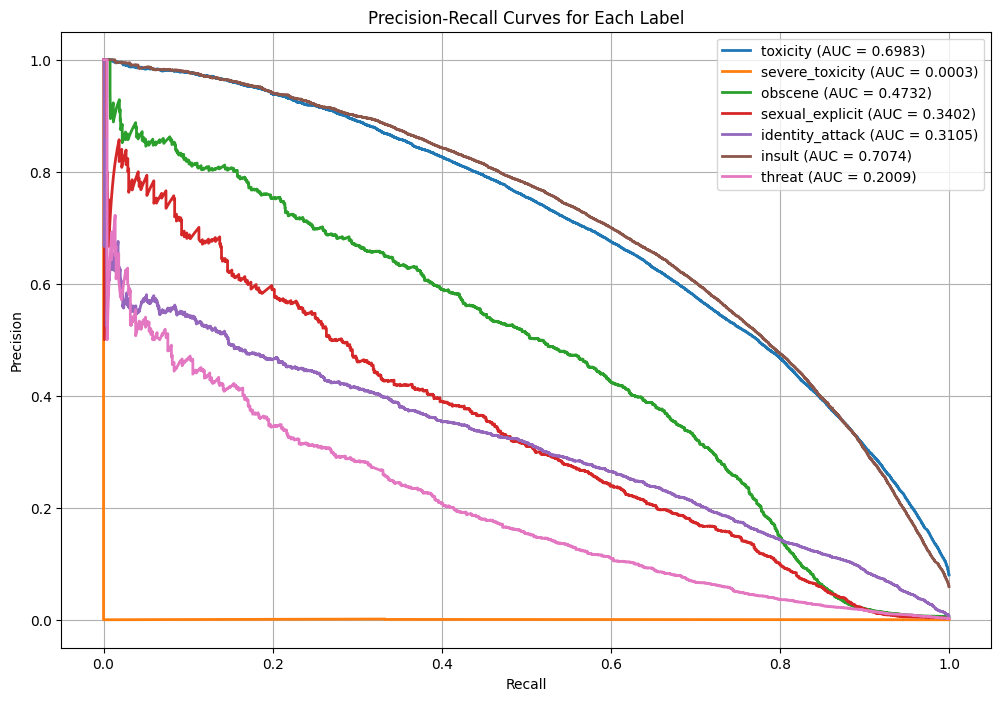

In [8]:
best_model, best_params, mean_pr_auc = optimize_multilabel_classifier(
    X_train_tfidf, y_train, X_test_tfidf, y_test, toxic_categories,
    use_random_search=True, n_iter=10, n_jobs=1, reduced_params=False
)


Evaluating the model...


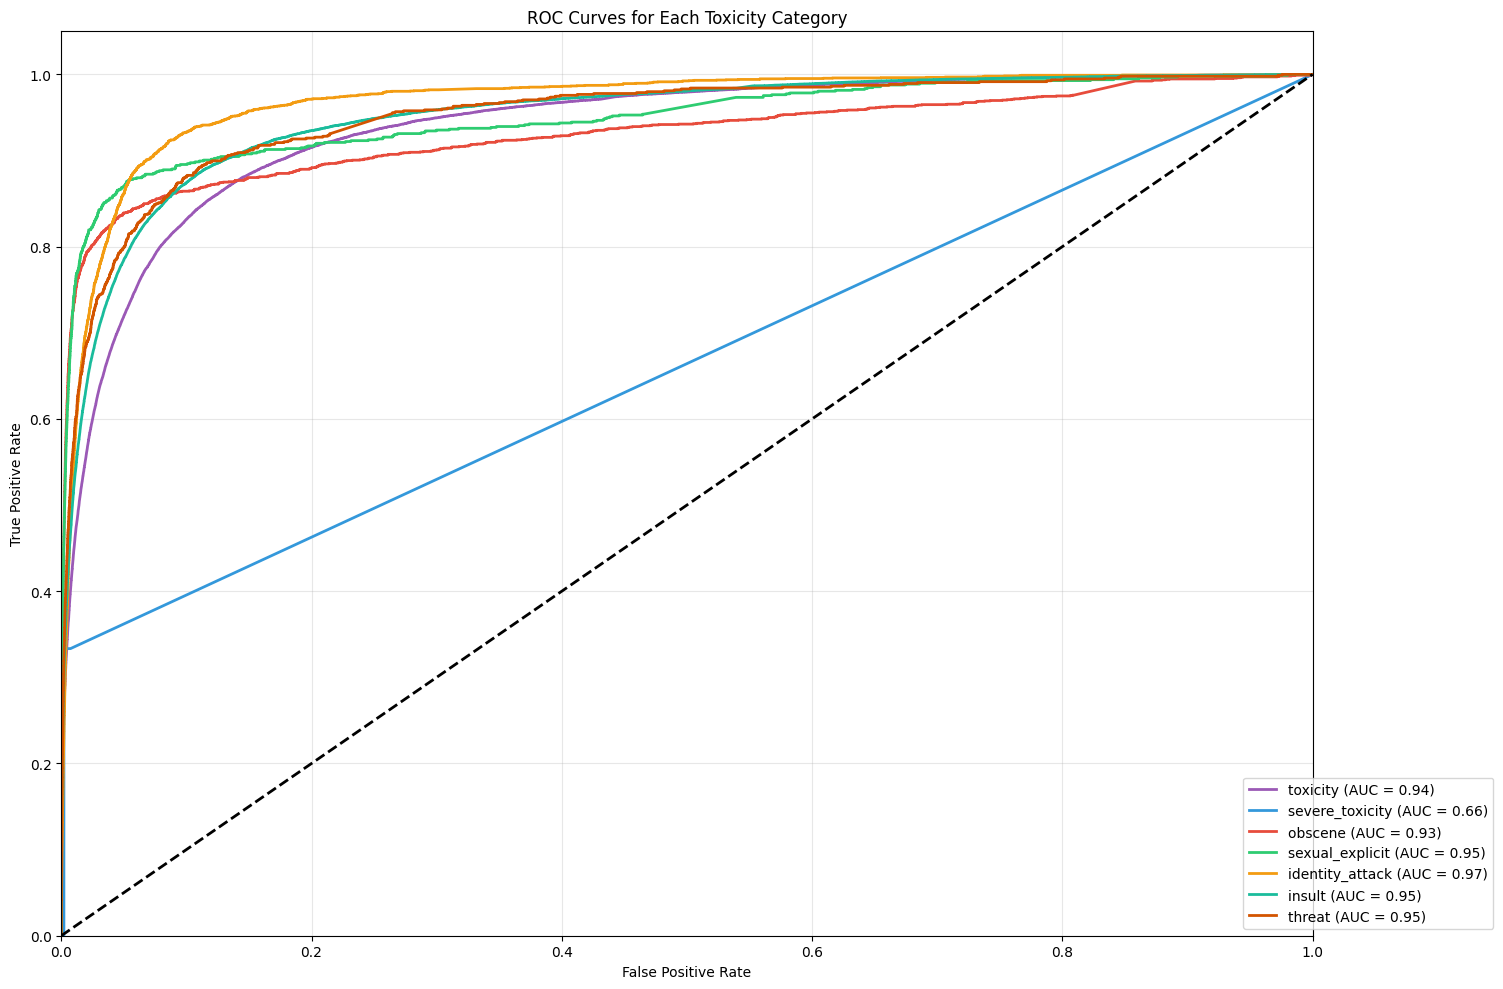

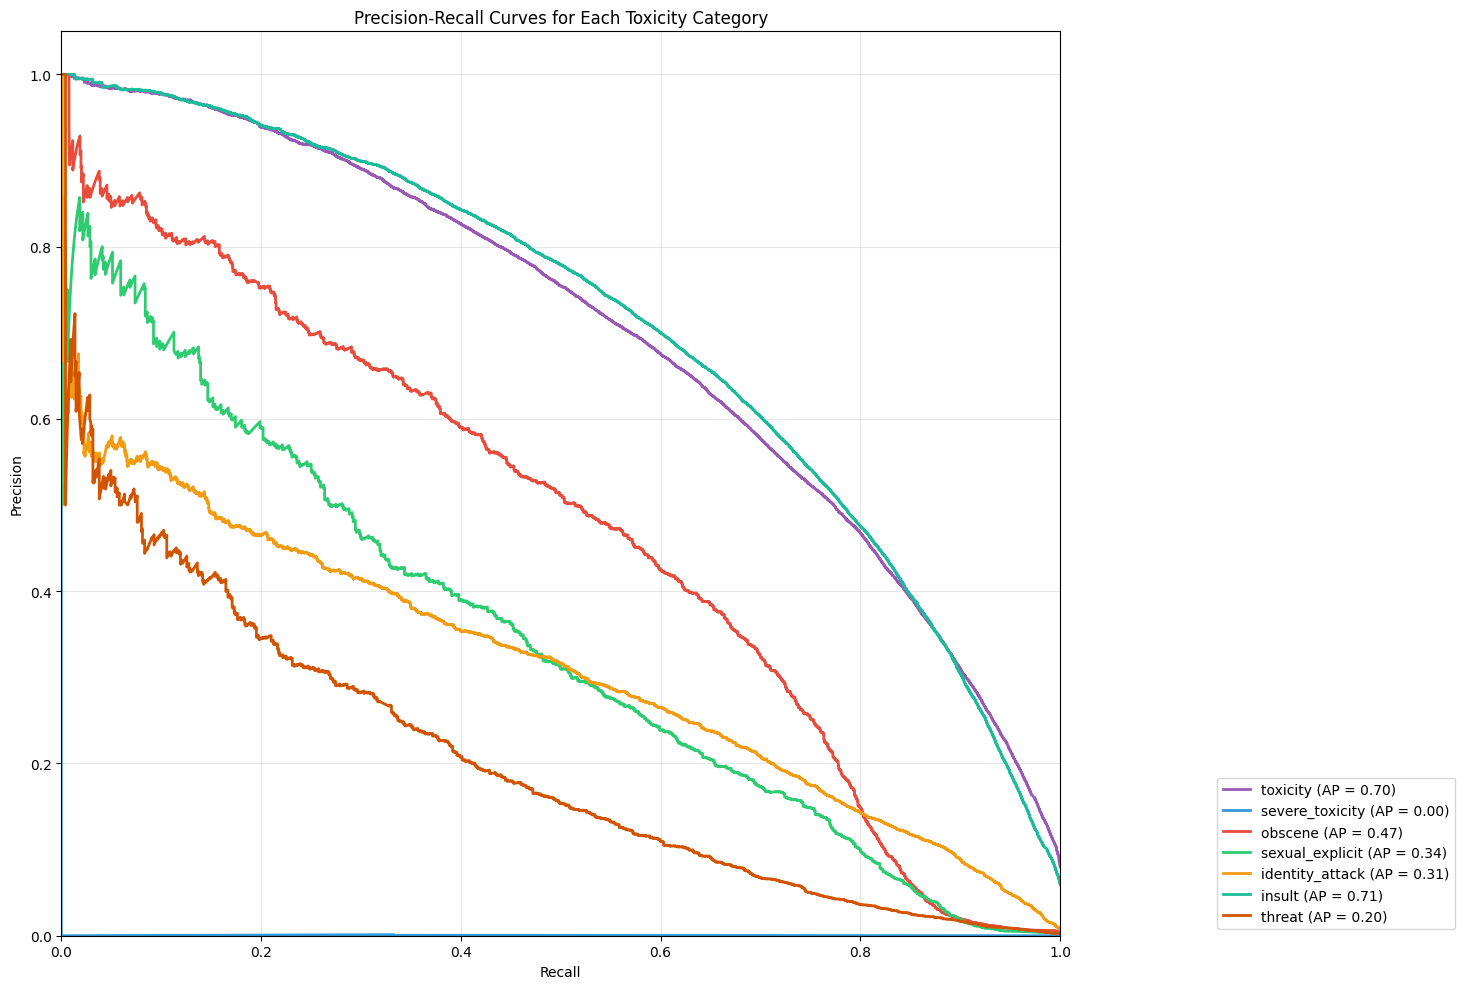


Mean ROC AUC: 0.908
Mean Average Precision: 0.390


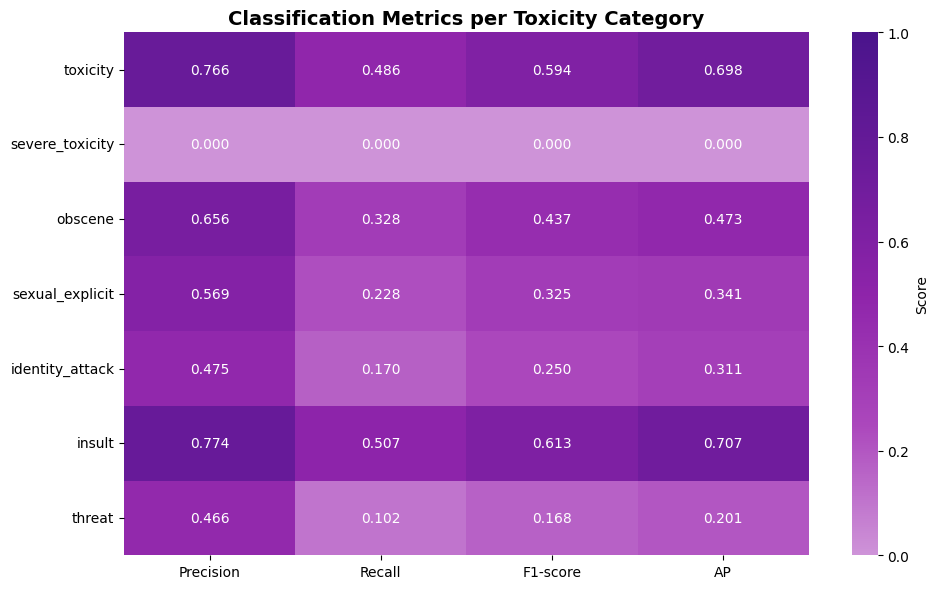

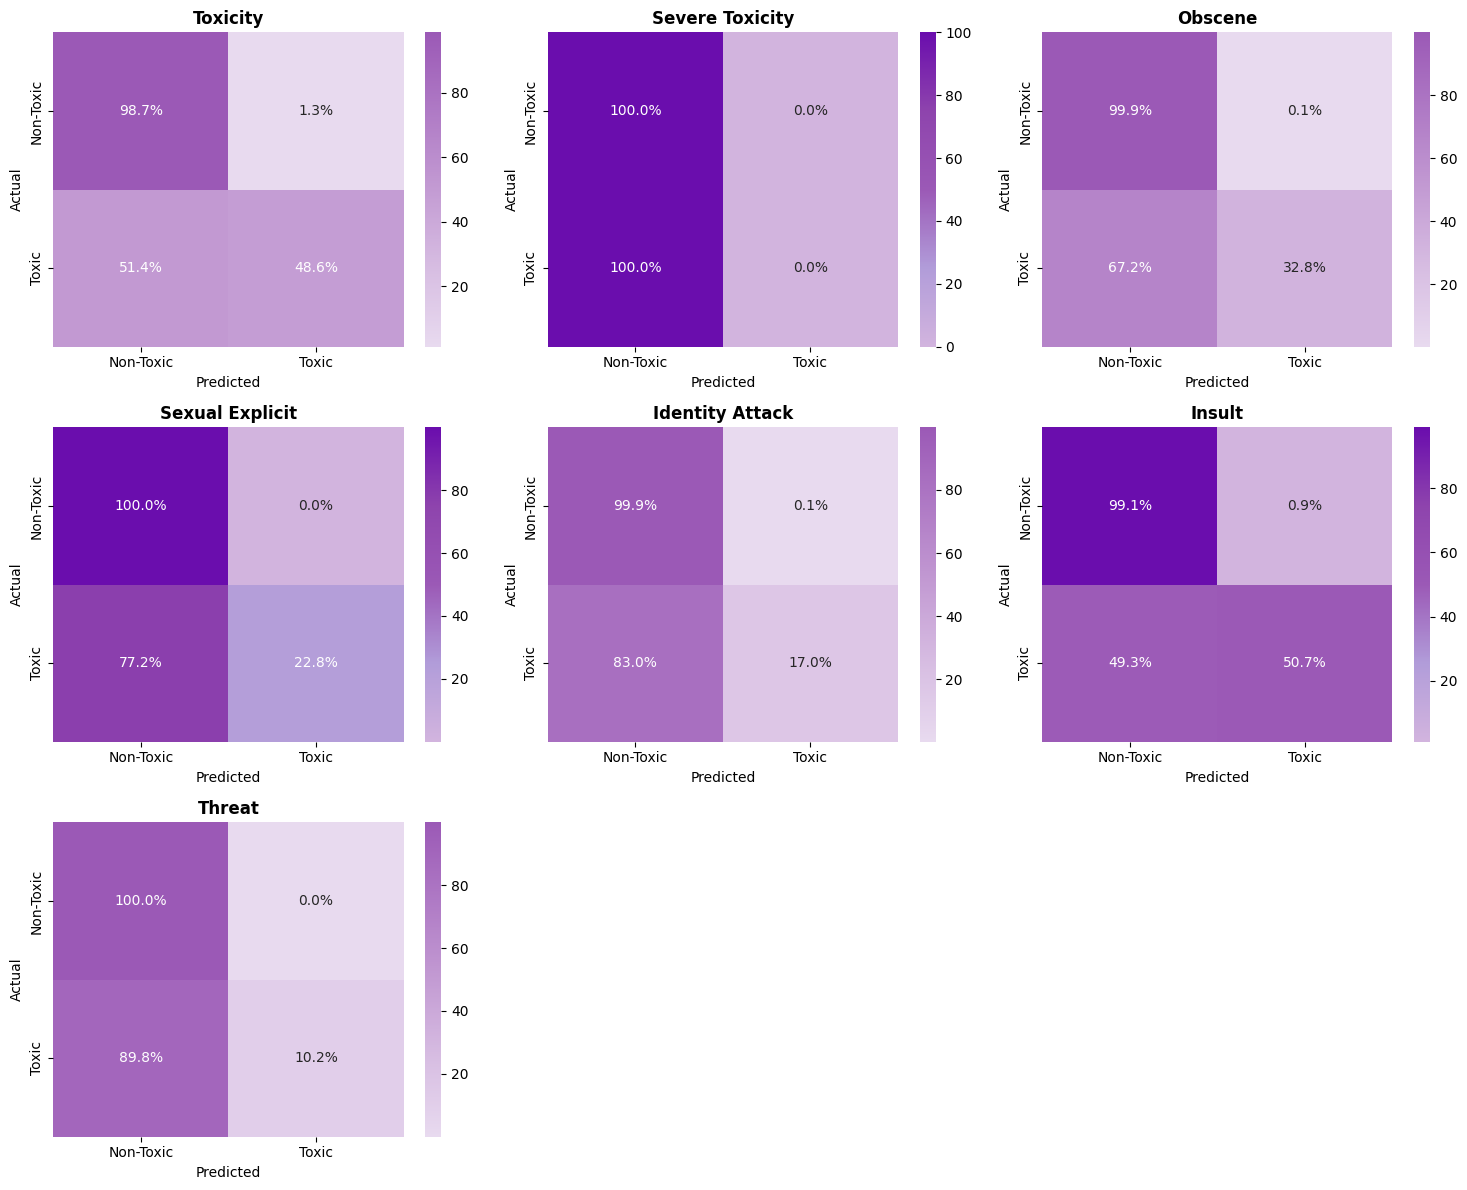


Detailed Classification Report:
--------------------------------------------------

Category: toxicity
              precision    recall  f1-score   support

           0       0.96      0.99      0.97    367948
           1       0.77      0.49      0.59     31956

    accuracy                           0.95    399904
   macro avg       0.86      0.74      0.78    399904
weighted avg       0.94      0.95      0.94    399904


Category: severe_toxicity
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    399901
           1       0.00      0.00      0.00         3

    accuracy                           1.00    399904
   macro avg       0.50      0.50      0.50    399904
weighted avg       1.00      1.00      1.00    399904


Category: obscene
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    397825
           1       0.66      0.33      0.44      2079

    accuracy                    

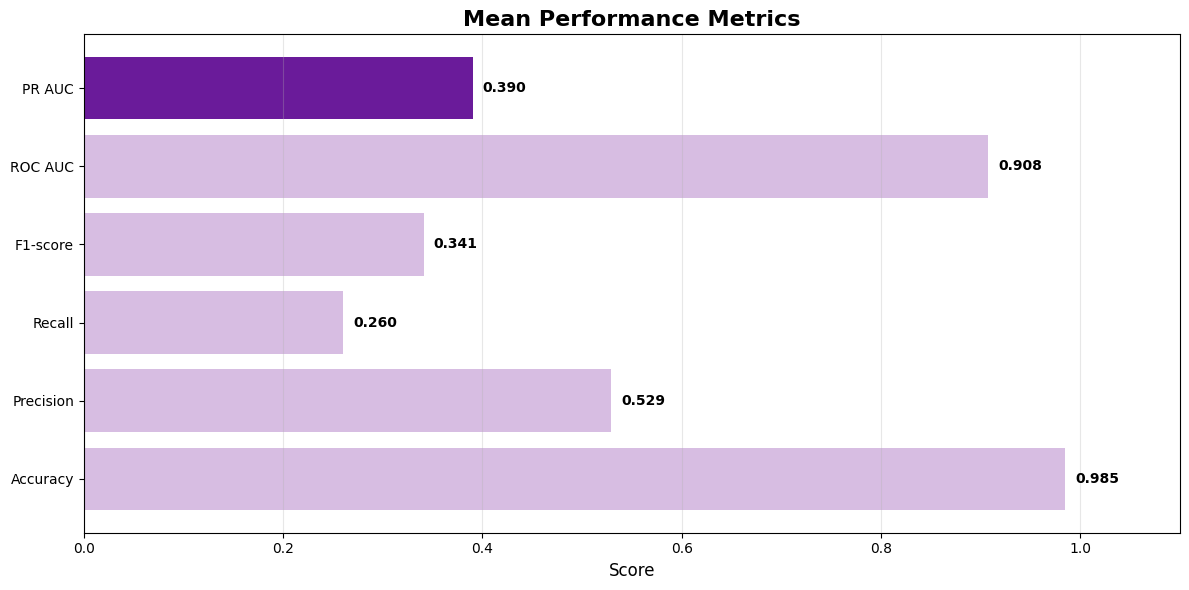

In [9]:
# Prepare the test set
y_test_binary = (y_test >= 0.5).astype(int)  # Convert to binary
test_set = (X_test_tfidf, y_test_binary)

# Evaluate the model
print("Evaluating the model...")
evaluation_results = evaluate_model(
    model=best_model,
    test_set=test_set,
    threshold=0.5,
    figsize=(15, 10)
)